### Introduction to Partial Derivatives

Partial derivatives measure the rate of change of a multivariable function with respect to one variable at a time, holding the other variables constant.

#### Notation
- The partial derivative of $f(x, y)$ with respect to $x$ is denoted as $\frac{\partial f}{\partial x}$.
- Similarly, the partial derivative with respect to $y$ is denoted as $\frac{\partial f}{\partial y}$.

#### Example
Consider the function $f(x, y) = x^2y + 3xy^2$.

- The partial derivative with respect to $x$: $\frac{\partial f}{\partial x} = 2xy + 3y^2$.
- The partial derivative with respect to $y$: $\frac{\partial f}{\partial y} = x^2 + 6xy$.

This means $\frac{\partial f}{\partial x}$ measures how $f$ changes as $x$ changes (while keeping $y$ constant), and $\frac{\partial f}{\partial y}$ measures how $f$ changes as $y$ changes (while keeping $x$ constant).




### Black-Scholes Formula for a European Call an Put Option

The price of a European call option $C$ is given by:

$$ c(t) = S(t) \cdot N(d_1) - e^{-r(T-t)} X\cdot N(d_2) $$


Similarly, the price of a European put option $p(t)$ is given by:

$$ p(t) = e^{-r(T-t)} X \cdot N(-d_2) - S(t) \cdot N(-d_1) $$


where:

- $S(t)$: Stock price at time $t$
- $X$: Strike price of the option
- $T$: Time to expiration
- $r$: Risk-free interest rate
- $N(x)$: Cumulative distribution function of the standard normal distribution
- $d_1$ and $d_2$ are calculated as:

$$ d_1 = \frac{\ln(S(t) / X) + (r + \sigma^2 / 2)(T-t)}{\sigma \sqrt{T-t}} $$
$$ d_2 = d_1 - \sigma \sqrt{T-t} $$

- $\sigma$: Volatility (Standard Deviation) of the stock's returns



### Introduction to the Greeks

The Greeks measure the sensitivity of option prices to various factors. 

#### Delta ($\Delta=\frac{\partial V}{\partial S}$)
- Measures the rate of change of the option price with respect to changes in the underlying asset's price.
- For call options: $\Delta = N(d_1)$
- For put options: $\Delta = N(d_1) - 1$

#### Gamma ($\Gamma=\frac{\partial^2 V}{\partial S^2}$)
- Measures the rate of change in Delta with respect to changes in the underlying asset's price.
- $\Gamma = \frac{N'(d_1)}{S \sigma \sqrt{T-t}}$

#### Theta ($\Theta=-\frac{\partial V}{\partial \tau} $) $(\tau:=T-t)$
- Measures the rate of change of the option price with respect to time (time decay).
- Call options: $\Theta = -\frac{S N'(d_1) \sigma}{2 \sqrt{T-t}} - r X e^{-r(T-t)} N(d_2)$
- Put options: $\Theta = -\frac{S N'(d_1) \sigma}{2 \sqrt{T-t}} + r X e^{-r(T-t)} N(-d_2)$

#### Vega ($\nu=\frac{\partial V}{\partial \sigma}$)
- Measures the rate of change of the option price with respect to volatility of the underlying asset.
- $\nu = S \sqrt{T-t} N'(d_1)$

#### Rho ($\rho=\frac{\partial V}{\partial r}$)
- Measures the rate of change of the option price with respect to the risk-free interest rate.
- For call options: $\rho = (T-t) X e^{-r(T-t)} N(d_2)$
- For put options: $\rho = -(T-t) X e^{-r(T-t)} N(-d_2)$


In [141]:
from scipy.stats import norm
import numpy as np

def european_call_price_and_greeks(S, X, T, r, sigma):
    """
    Calculate the price and Greeks for a European call option.

    Parameters:
    S (float): Current stock price
    X (float): Strike price
    T (float): Time to expiration in years
    r (float): Risk-free interest rate
    sigma (float): Volatility of the stock

    Returns:
    tuple: Option price, Delta, Gamma, Theta, Vega, Rho
    """
    # Calculate d1 and d2
    d1 = (np.log(S / X) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    # Calculate the price of the call option
    price = S * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2)

    # Calculate Greeks
    delta = norm.cdf(d1)
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    theta = -S * norm.pdf(d1) * sigma / (2 * np.sqrt(T)) - r * X * np.exp(-r * T) * norm.cdf(d2)
    vega = S * np.sqrt(T) * norm.pdf(d1)
    rho = T * X * np.exp(-r * T) * norm.cdf(d2)

    return price, delta, gamma, theta, vega, rho

# Example usage
S0 = 100  # Current stock price
X = 100   # Strike price
T = 1    # Time to expiration (1 year)
r = 0.05  # Risk-free interest rate
sigma = 0.2  # Volatility of the stock

price, delta, gamma, theta, vega, rho = european_call_price_and_greeks(S0, X, T, r, sigma)
print(f"Call Price: {price:.2f}, Delta: {delta:.2f}, Gamma: {gamma:.2f}, Theta: {theta:.2f}, Vega: {vega:.2f}, Rho: {rho:.2f}")


Call Price: 10.45, Delta: 0.64, Gamma: 0.02, Theta: -6.41, Vega: 37.52, Rho: 53.23


In [142]:
#if jax is not installed, uncomment follwoing line
#%pip install jax jaxlib
import jax.numpy as jnp
from jax import grad, jit
import jax

# Black-Scholes formula for European call option
def black_scholes_call(S, K, T, r, sigma):
    d1 = (jnp.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * jnp.sqrt(T))
    d2 = d1 - sigma * jnp.sqrt(T)
    call_price = S * jax.scipy.stats.norm.cdf(d1) - K * jnp.exp(-r * T) * jax.scipy.stats.norm.cdf(d2)
    return call_price

# Function to calculate Greeks based on input
def calculate_greeks(S, K, T, r, sigma, dS=0, dT=0, dr=0, dsigma=0):
    call_price_fn = lambda S, T, r, sigma: black_scholes_call(S, K, T, r, sigma)
    
    # Differentiating w.r.t. S, T, r, sigma based on input
    for _ in range(dS):
        call_price_fn = jit(grad(call_price_fn, argnums=0))
    for _ in range(dT):
        call_price_fn = jit(grad(call_price_fn, argnums=1))
    for _ in range(dr):
        call_price_fn = jit(grad(call_price_fn, argnums=2))
    for _ in range(dsigma):
        call_price_fn = jit(grad(call_price_fn, argnums=3))
    
    return call_price_fn(S, T, r, sigma)

# Example usage
S = 100.  # Underlying asset price
K = 100.  # Strike price
T = 1.    # Time to maturity
r = 0.05 # Risk-free rate
sigma = 0.2  # Volatility

# Calculate Delta (∂Price/∂S)
delta = calculate_greeks(S, K, T, r, sigma, dS=3, dT=2, dr=1)
print(f"Delta: {delta}")

# Calculate Theta (∂Price/∂T)
theta = calculate_greeks(S, K, T, r, sigma, dT=1)
print(f"Theta: {theta}")



Delta: -0.00410041119903326
Theta: 6.414027690887451


### Question 1

Plato constructs a Butterfly Spread using European call options on Apple Inc. (AAPL).

#### Portfolio Setup:
- **Long Calls**: 10 AAPL call options, strike $\$140$, 6 months to expiration.
- **Short Calls**: 20 AAPL call options, strike $\$150$, 6 months to expiration.
- **Long Calls**: 10 AAPL call options, strike $\$160$, 6 months to expiration.

AAPL current price: $\$145$, annual volatility: 25%, risk-free rate: 3%, no dividends.
 For each position, calculate $\Delta, \Gamma, \Theta, \nu, \rho$. 




In [121]:
# Portfolio parameters
S = 145  # Current AAPL stock price
T = 0.5  # Time to expiration in years (6 months)
r = 0.03  # Risk-free interest rate
sigma = 0.25  # Volatility
strikes = [140, 150, 160]  # Strike prices
quantities = [10, -20, 10]  # Quantities for each strike price position

# Initialize net Greeks
net_price, net_delta, net_gamma, net_theta, net_vega, net_rho = 0, 0, 0, 0, 0, 0

# Calculate and sum Greeks for the entire portfolio
for X, quantity in zip(strikes, quantities):
    price, delta, gamma, theta, vega, rho = european_call_price_and_greeks(S, X, T, r, sigma)
    net_price += price * quantity
    net_delta += delta * quantity
    net_gamma += gamma * quantity
    net_theta += theta * quantity
    net_vega += vega * quantity
    net_rho += rho * quantity

print(f"Net Portfolio Greeks:")
print(f"Net Price: {net_price:.2f}")
print(f"Net Delta: {net_delta:.2f}")
print(f"Net Gamma: {net_gamma:.2e}")
print(f"Net Theta: {net_theta:.2f}")
print(f"Net Vega: {net_vega:.2f}")
print(f"Net Rho: {net_rho:.2f}")

Net Portfolio Greeks:
Net Price: 14.40
Net Delta: 0.10
Net Gamma: -2.14e-02
Net Theta: 14.03
Net Vega: -56.19
Net Rho: 0.32


### Net Portfolio Greeks Analysis

Plato's Butterfly Spread shows the following net Greeks:

- **Net Delta (0.10)**: Indicates a minimal positive exposure to the underlying's price movement. A $1 increase in AAPL's price could lead to an approximate $0.10 increase in the portfolio's value.

- **Net Gamma (-2.14e-02)**: Suggests a negative convexity, meaning the portfolio's delta becomes less positive as AAPL's price rises. This is typical for Butterfly Spreads, as they are neutral strategies with maximum profit at the strike price of the short calls.

- **Net Theta (14.03)**: Implies a positive time decay effect. The portfolio is expected to gain approximately $14.03 per day, all else being equal, benefiting from the erosion of option time value as expiration approaches.

- **Net Vega (-56.19)**: Indicates a negative sensitivity to volatility. An increase in implied volatility by 1% could decrease the portfolio's value by about $56.19, reflecting the short vega exposure due to the net short option positions.

- **Net Rho (0.32)**: Shows a slight sensitivity to interest rates, with the portfolio value expected to increase by $0.32 for a 1% rise in the risk-free rate, suggesting a minor long interest rate exposure.

These results provide insights into the risk profile and sensitivities of Plato's Butterfly Spread strategy.


### Self-Financing Delta Hedging Simulation

This Python code simulates a self-financing delta hedging strategy for a European call option on a stock, demonstrating how to maintain a delta-neutral portfolio through continuous rebalancing. The strategy involves short selling a call option, buying $\Delta$ shares of the underlying stock to hedge, and investing the remaining funds in a risk-free bank account. 


- **Initial Setup**: The portfolio starts with an amount equal to the call option's price. The option is shorted, the corresponding $\Delta$ shares of stock are purchased, and any remaining funds are placed in a risk-free bank account.
- **Delta ($\Delta$)**: Represents the hedge ratio, indicating the number of stock shares needed to hedge against the price movement of one option contract. Calculated using the Black-Scholes model.
- **Rebalancing**: At each time step, the stock position is adjusted to the new $\Delta$, ensuring the portfolio remains delta-neutral. The adjustment is financed by the change in the option's value, keeping the strategy self-financing.



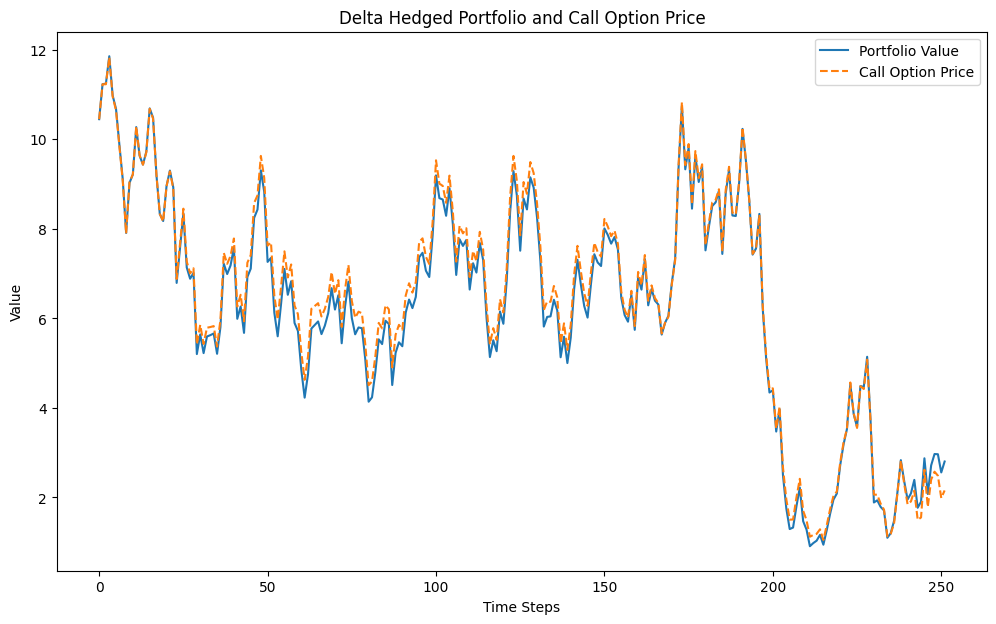

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = np.where(T <= 0, np.maximum(S-K, 0), S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
    return call_price

def delta_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    delta = np.where(T <= 0, 1.0 * (S > K), norm.cdf(d1))
    return delta

# Parameters
S0, K, T, r, sigma = 100, 100, 1, 0.05, 0.2
dt, N = 1/252, int(T / (1/252))

# Simulate stock path
stock_price_changes = (r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * np.random.randn(N-1)
S = S0 * np.exp(np.cumsum(np.insert(stock_price_changes, 0, 0)))

# Time to maturity for each step
T_remaining = T - np.arange(N) * dt

# Calculate option prices and delta
call_prices = black_scholes_call(S, K, T_remaining, r, sigma)
D = delta_call(S, K, T_remaining, r, sigma)

# Calculate stock investment based on delta
stock_investment = D * S

# Initialize bank investment and portfolio value arrays
bank_investment = np.zeros(N)
Pi = np.zeros(N)

# Initial bank investment and portfolio value
bank_investment[0] = call_prices[0] - stock_investment[0]
Pi[0] = bank_investment[0] + stock_investment[0] - call_prices[0]

# Update bank investment and portfolio value for each step
for t in range(1, N):
    bank_investment[t] = bank_investment[t-1] * np.exp(r * dt) - (stock_investment[t] -D[t-1]*S[t])

# Calculate portfolio value
Pi = bank_investment  + stock_investment #- call_prices

# Plot results
plt.figure(figsize=(12, 7))
plt.plot(Pi, label='Portfolio Value')
plt.plot(call_prices, label='Call Option Price', linestyle='--')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Delta Hedged Portfolio and Call Option Price')
plt.legend()
plt.show()



### Delta-Gamma Hedging Strategy Overview

This code implements a Delta-Gamma hedging strategy for a European call option using simulated stock prices.
We conduct our delta gamma hedge for the call option using the underlying stock and an option expiring 1 additonal year  in the future.

#### Hedge Components:
- **Option Pricing**: Black-Scholes model for call prices, Delta ($\Delta$), and Gamma ($\Gamma$).
- **Portfolio**: $\Pi = -V + A \cdot S + B \cdot \text{Option}$

#### Mathematical Setup:
1. **Delta Neutrality**: $\frac{d\Pi}{dS} = 0 \Rightarrow A = \Delta - B \cdot \Delta_{\text{option}}$
2. **Gamma Neutrality**: $\frac{d^2\Pi}{dS^2} = 0 \Rightarrow B = \frac{\Gamma}{\Gamma_{\text{option}}}$

#### Execution:
- Simulate $S$ using geometric Brownian motion.
- Calculate $\Delta$, $\Gamma$ for the portfolio and auxiliary option.
- Solve for $A$ and $B$ to maintain neutrality.
- Update portfolio value: $\Pi$.

#### Result:
- Plots portfolio value ($\Pi$) and call option price over time.


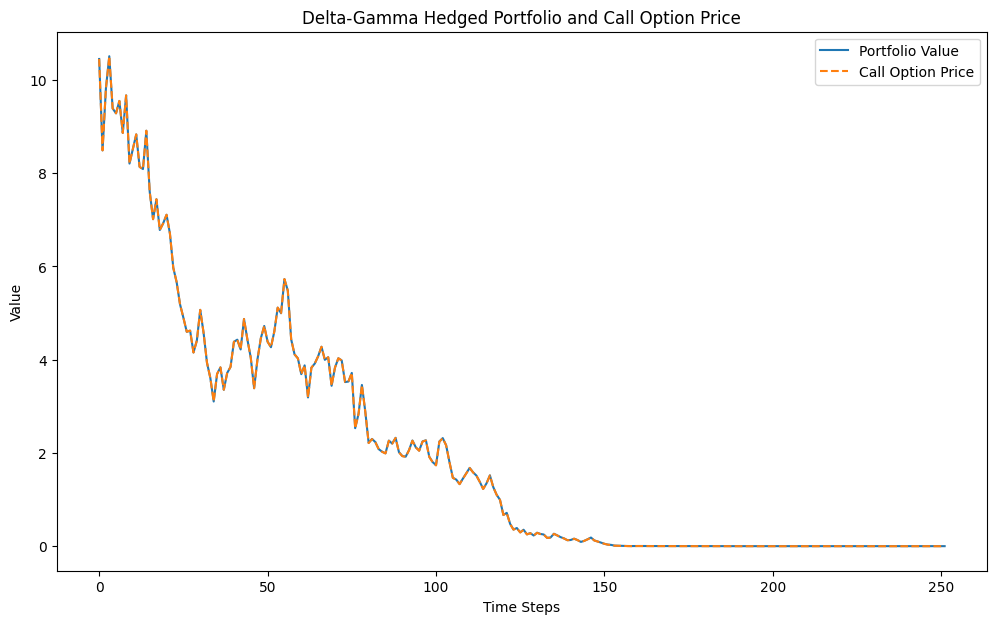

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = np.where(T <= 0, np.maximum(S-K, 0), S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
    return call_price

def delta_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    delta = np.where(T <= 0, 1.0 * (S > K), norm.cdf(d1))
    return delta

def gamma_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    gamma = np.where(T <= 0, 0, norm.pdf(d1) / (S * sigma * np.sqrt(T)))
    return gamma

# Parameters
S0, K, T, r, sigma = 100, 100, 1, 0.05, 0.2
dt, N = 1/252, int(T / (1/252))

# Simulate stock path
stock_price_changes = (r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * np.random.randn(N-1)
S = S0 * np.exp(np.cumsum(np.insert(stock_price_changes, 0, 0)))

# Time to maturity for each step
T_remaining = T - np.arange(N) * dt

# Calculate option prices and Greeks
call_prices = black_scholes_call(S, K, T_remaining, r, sigma)
option_prices = black_scholes_call(S, K, T_remaining + 1, r, sigma)
D = delta_call(S, K, T_remaining, r, sigma)
G = gamma_call(S, K, T_remaining, r, sigma)
D_option = delta_call(S, K, T_remaining + 1, r, sigma)
G_option = gamma_call(S, K, T_remaining + 1, r, sigma)

# Calculate A, B, stock, option, and bank investments
B = G / G_option
A = D - B * D_option
option_investment = B * option_prices
stock_investment = A * S
bank_investment = np.zeros(N)
bank_investment[0] = call_prices[0] - stock_investment[0] - option_investment[0]

# Update bank investment for each step
for t in range(1, N):
    bank_investment[t] = bank_investment[t-1] * np.exp(r * dt) - (stock_investment[t] - A[t-1] * S[t]) - (option_investment[t] - B[t-1] * option_prices[t])

# Calculate portfolio value
Pi = bank_investment + option_investment + stock_investment #- call_prices

# Plot results
plt.figure(figsize=(12, 7))
plt.plot(Pi, label='Portfolio Value')
plt.plot(call_prices, label='Call Option Price', linestyle='--')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Delta-Gamma Hedged Portfolio and Call Option Price')
plt.legend()
plt.show()